# Introduction to Deep Learning 67822 - [Ex1](https://docs.google.com/document/d/11Q1ejfwTH_tHjdQob0gYLA3bS88lNsBStpBWz085rB0/edit?tab=t.0)
### NAME1 (ID1) & NAME2 (ID2)

### Section 1: Load and Prepare the Data
#### Split training data (from the .txt files)
We are training a model to classify 9-mer peptides based on whether they are detected by the immune system via specific HLA alleles. Each positive sample is associated with one of six common alleles. The negative samples are peptides not detected by any of the alleles.

When splitting the data into training and test sets, it’s crucial to avoid introducing bias. One tempting idea is to take the first 90% of each file for training and the last 10% for testing. However, this assumes that the peptide order inside each file is random — which may not be true. The files might be sorted by binding strength, similarity, or even alphabetically, which could skew the distribution.

To prevent such biases and ensure fair training and evaluation, we use a **stratified random split per allele**:

1. We load and shuffle the peptides from each positive allele file individually.
2. We split each file into a 90% training / 10% test set.
3. We do the same for the negative examples (from `negs.txt`).
4. Finally, we combine all subsets and shuffle them again.

This approach ensures that all alleles are represented in both training and test sets, the overall class balance between positive and negative is maintained and no ordering bias from the original files leaks into the learning process.

In [25]:
import os
import random
from pathlib import Path

# Config
data_dir = Path("Data/HLA_Dataset")
train_ratio = 0.9

# Define allele-to-label mapping
allele_label_map = {
    "A0101": 1,
    "A0201": 2,
    "A0203": 3,
    "A0207": 4,
    "A0301": 5,
    "A2402": 6,
    "NEG": 0
}

# Locate all positive allele files
allele_files = [f for f in data_dir.glob("*.txt") if "neg" not in f.name]

# Store train/test samples
pos_train, pos_test = [], []

# Process each allele file separately
for file in allele_files:
    allele = file.stem.replace("_pos", "")
    label = allele_label_map[allele]
    with open(file) as f:
        peptides = [line.strip() for line in f if line.strip()]
        random.shuffle(peptides)
        split_idx = int(len(peptides) * train_ratio)
        pos_train += [(pep, allele, label) for pep in peptides[:split_idx]]
        pos_test  += [(pep, allele, label) for pep in peptides[split_idx:]]

# Process negatives
with open(data_dir / "negs.txt") as f:
    neg_peptides = [line.strip() for line in f if line.strip()]
    random.shuffle(neg_peptides)
    split_idx = int(len(neg_peptides) * train_ratio)
    neg_train = [(pep, "NEG", 0) for pep in neg_peptides[:split_idx]]
    neg_test  = [(pep, "NEG", 0) for pep in neg_peptides[split_idx:]]

# Combine and shuffle
train_data = pos_train + neg_train
test_data = pos_test + neg_test
random.shuffle(train_data)
random.shuffle(test_data)

# Print final stats
from collections import Counter

def print_dist(data, name):
    counter = Counter([label for _, _, label in data])
    total = sum(counter.values())
    print(f"\n{name} set distribution:")
    for lbl in sorted(counter):
        allele = [a for a, l in allele_label_map.items() if l == lbl][0]
        print(f"  {allele:6s} (label {lbl}): {counter[lbl]} samples ({100 * counter[lbl]/total:.2f}%)")

print(f"Train set size: {len(train_data)} ({((len(train_data) / (len(train_data) + len(test_data))) * 100):.2f}%))")
print(f"Test set size: {len(test_data)} ({((len(test_data) / (len(train_data) + len(test_data))) * 100):.2f}%)")
print_dist(train_data, "Train")
print_dist(test_data, "Test")

Train set size: 33642 (89.99%))
Test set size: 3741 (10.01%)

Train set distribution:
  NEG    (label 0): 22042 samples (65.52%)
  A0101  (label 1): 1142 samples (3.39%)
  A0201  (label 2): 2352 samples (6.99%)
  A0203  (label 3): 1645 samples (4.89%)
  A0207  (label 4): 2982 samples (8.86%)
  A0301  (label 5): 1493 samples (4.44%)
  A2402  (label 6): 1986 samples (5.90%)

Test set distribution:
  NEG    (label 0): 2450 samples (65.49%)
  A0101  (label 1): 127 samples (3.39%)
  A0201  (label 2): 262 samples (7.00%)
  A0203  (label 3): 183 samples (4.89%)
  A0207  (label 4): 332 samples (8.87%)
  A0301  (label 5): 166 samples (4.44%)
  A2402  (label 6): 221 samples (5.91%)


### Section 2 – Peptide Representation

#### How would you represent these 9-mers of amino acids?

We considered two approaches:

**1. One-hot encoding:**  
Each amino acid is represented as a 20-dimensional one-hot vector. For a 9-mer peptide, this would require 180 input features. While this is straightforward, it’s sparse and does not capture biological similarities between amino acids.

**2. Embedding (used):**  
Instead, we map each amino acid to a dense embedding vector of size `d` (e.g., 4 or 8). This allows the model to learn meaningful representations during training, such as that hydrophobic or acidic amino acids may behave similarly.

Each peptide is converted to 9 indices (integers from 0–19), then embedded to get a `9 × d` matrix, which is then flattened for input to an MLP.

#### How would you represent the associate alleles?

Each positive sample comes from a known allele, and each negative sample is from none. We label:
- `0` → NEG (non-detecting)
- `1–6` → Alleles A0101 to A2402

This forms a 7-class multi-class classification problem.


In [26]:
# Amino acid to index mapping
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_idx = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

# Convert peptide (string of 9 amino acids) to list of indices
def peptide_to_indices(peptide):
    return [aa_to_idx[aa] for aa in peptide]

import torch

# Split features (X) and labels (y) for train and test
X_train = [peptide_to_indices(p) for p, _, _ in train_data]
y_train = [label for _, _, label in train_data]

X_test  = [peptide_to_indices(p) for p, _, _ in test_data]
y_test  = [label for _, _, label in test_data]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test  = torch.tensor(X_test, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check a sample
print("\nExample input (peptide indices):", X_train[0])
print("Corresponding label (allele class):", y_train[0])

X_train shape: torch.Size([33642, 9])
y_train shape: torch.Size([33642])
X_test shape: torch.Size([3741, 9])
y_test shape: torch.Size([3741])

Example input (peptide indices): tensor([13,  9, 19,  3,  5,  8,  3, 13, 10])
Corresponding label (allele class): tensor(0)


### Section 3 – Network Architecture

#### What will the network’s input dimension be?
With embeddings of size `d` and peptides of length 9, the input dimension is `9 × d`.  
For example, using `d = 4`, the input to the MLP is of size 36.

#### Implement an MLP that keeps this dimension for 2 inner layers
We construct a small feedforward neural network (MLP) with the following layers:
- **Embedding layer:** Maps 20 amino acid types to `d`-dimensional learnable vectors.
- **Flatten layer:** Concatenates the 9 embedded amino acids into a single vector of size `9 × d`.
- **Two hidden layers:** Fully connected, both using the same dimension (`9 × d`) with ReLU activations.
- **Output layer:** A linear layer with 7 outputs, representing the 7 classification labels (6 alleles + NEG).

We use `CrossEntropyLoss` as our loss function, and the `Adam` optimizer. During training, we track both training and validation loss.

#### Does the input dimension cause training problems?
In our setup, Each amino acid is embedded into a small vector (e.g. 4D), A peptide of length 9 becomes a 36D input vector (`9 × 4`) and the hidden layers also use this dimension.

This is a relatively small dimensional space (especially compared to one-hot encoding with 180 features). The network trains quickly and converges within a few epochs. No numerical instability or overfitting is observed.

**Conclusion:** The embedding-based representation allows the model to learn efficiently without overfitting or struggling with too high-dimensional sparse inputs.

#### Architecture Overview
We use a Multi-Layer Perceptron (MLP) that receives a 9-mer peptide encoded as indices of amino acids (integers from 0 to 19).
- We pass the input through an `nn.Embedding` layer that maps each amino acid to a learnable dense vector of dimension `d` (e.g., 4 or 8).
- The resulting tensor of shape `[batch_size, 9, d]` is flattened into `[batch_size, 9 × d]`.
- This is passed through two fully connected layers of the same size, with ReLU activations.
- The final layer outputs 7 logits corresponding to 7 classes (6 alleles + negative class).
- We apply `CrossEntropyLoss`, which internally applies softmax + log likelihood.

We also track training and test loss and accuracy over multiple epochs.


#### Defining the MLP Model

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class PeptideMLP(nn.Module):
    def __init__(self, emb_dim=4, hidden_dim=36):
        super().__init__()

        # Embedding: each of the 20 amino acids gets a vector of size `emb_dim`
        self.embedding = nn.Embedding(num_embeddings=20, embedding_dim=emb_dim)

        # Input size to the MLP is: 9 amino acids × emb_dim (e.g. 9×4=36)
        input_dim = 9 * emb_dim

        # First hidden layer (same size as input)
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Second hidden layer (also same size, as required)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Output layer: 7 classes (0=NEG, 1–6=alleles)
        self.out = nn.Linear(hidden_dim, 7)

    def forward(self, x):
        """
        x: input tensor of shape [batch_size, 9]
           where each row is a sequence of 9 amino acid indices
        """
        # Step 1: Apply embedding layer → shape becomes [batch_size, 9, emb_dim]
        x = self.embedding(x)

        # Step 2: Flatten the embedded peptide → [batch_size, 9 * emb_dim]
        x = x.view(x.size(0), -1)

        # Step 3: Pass through 2 hidden layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Step 4: Output layer returns raw class scores (logits)
        return self.out(x)


#### Training Loop

In [30]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Hyperparameters
EPOCHS = 50            # Number of training epochs
BATCH_SIZE = 256       # Mini-batch size
EMB_DIM = 4            # Size of embedding vector per amino acid
HIDDEN_DIM = EMB_DIM * 9  # We use same size as input for hidden layers

# Prepare DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

# Instantiate the model
model = PeptideMLP(emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM)

# Optimizer: Adam (adaptive learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: multi-class classification → CrossEntropyLoss
# This combines softmax + negative log-likelihood in one function
loss_fn = nn.CrossEntropyLoss()

# For logging
train_losses = []
test_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()  # set model to training mode
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()          # reset gradients
        preds = model(xb)              # forward pass
        loss = loss_fn(preds, yb)      # compute loss
        loss.backward()                # backward pass (compute gradients)
        optimizer.step()               # update weights
        epoch_loss += loss.item() * xb.size(0)  # track total loss for average

    train_losses.append(epoch_loss / len(X_train))  # avg loss this epoch

    # Evaluation (no gradient tracking)
    model.eval()
    total, correct, test_loss = 0, 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            test_loss += loss.item() * xb.size(0)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)

    test_losses.append(test_loss / len(X_test))
    acc = correct / total * 100

    print(f"Epoch {epoch+1:2d}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | "
          f"Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {acc:.2f}%")


Epoch  1/50 | Train Loss: 1.3438 | Test Loss: 1.1132 | Test Accuracy: 65.49%
Epoch  2/50 | Train Loss: 1.0092 | Test Loss: 0.9076 | Test Accuracy: 65.92%
Epoch  3/50 | Train Loss: 0.8816 | Test Loss: 0.8407 | Test Accuracy: 66.37%
Epoch  4/50 | Train Loss: 0.8386 | Test Loss: 0.8119 | Test Accuracy: 67.20%
Epoch  5/50 | Train Loss: 0.8114 | Test Loss: 0.7910 | Test Accuracy: 68.24%
Epoch  6/50 | Train Loss: 0.7908 | Test Loss: 0.7751 | Test Accuracy: 68.97%
Epoch  7/50 | Train Loss: 0.7743 | Test Loss: 0.7599 | Test Accuracy: 68.97%
Epoch  8/50 | Train Loss: 0.7595 | Test Loss: 0.7494 | Test Accuracy: 69.85%
Epoch  9/50 | Train Loss: 0.7478 | Test Loss: 0.7384 | Test Accuracy: 68.83%
Epoch 10/50 | Train Loss: 0.7345 | Test Loss: 0.7323 | Test Accuracy: 69.87%
Epoch 11/50 | Train Loss: 0.7254 | Test Loss: 0.7177 | Test Accuracy: 70.41%
Epoch 12/50 | Train Loss: 0.7160 | Test Loss: 0.7116 | Test Accuracy: 70.46%
Epoch 13/50 | Train Loss: 0.7080 | Test Loss: 0.7058 | Test Accuracy: 70.49%

####  Plot Train/Test Loss

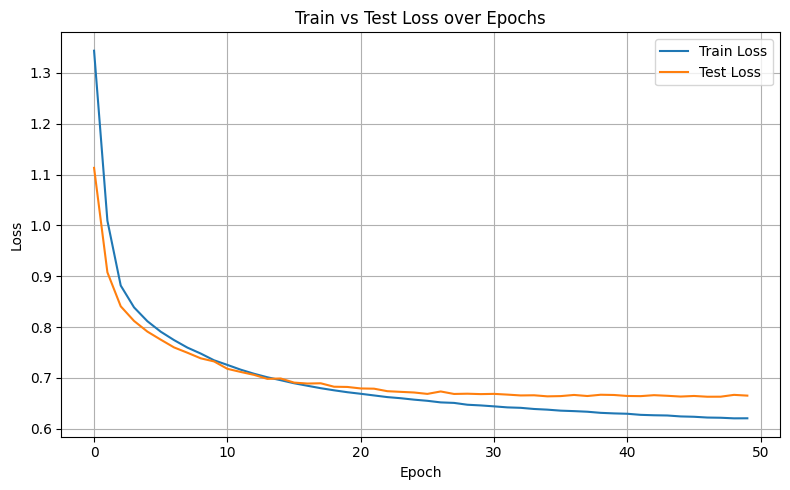

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Train vs Test Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()